# このReportの内容  
1. コスト関数
2. Activation/変換関数とLayerクラス
3. 数値微分/AutoBackpropagation
4. Batch Normalization/Weight Decay/Dropout
5. 各最適化手法(勾配降下法)
6. img2col, col2img, CNN

In [1]:
import numpy as np
import scipy as sp

# コスト関数

### MSE（平均二乗誤差）

$$
    E(\boldsymbol{w})=\frac{1}{n}\sum_{i=1}^{n}\sum_{k=1}^{d}(y_{ik} - \hat{y}_{ik})^2
$$

In [19]:
def mean_square_error(y, t):
    '''
    yはone-hot-vector 
    :param y: network output one-hot-vector: (バッチ数 x クラス数) or (1xクラス数) or 1次元配列
    :param t: target one-hot-vector:（バッチ数 x クラス数） または label-vector:（1 x バッチ数) or 1次元配列
    :return: 誤差値（スカラー）
    '''

    # 処理データが1個の場合
    if y.ndim == 1:
        #  (N,) -> (1,N)
        t = t.reshape(1, t.size)  
        y = y.reshape(1, y.size)

    # バッチサイズ    
    batch_size = y.shape[0]
    
    if t.size == y.size:
        # ターゲットtがone-hot-vector表現の場合,label-vector表現に変換
        t = t.argmax(axis=1)
    
    mse = -1*np.sum(np.log(y[np.arange(batch_size), t])) / batch_size

    return mse

### CEE（交差エントロピー誤差）

$$
        E(\boldsymbol{W})=-\frac{1}{n}\sum_{i=1}^{n}\sum_{k=1}^{d}y_{ik}\log{\hat{y}_{ik}} \quad(0 \leq y_ik \leq 1)
$$
$\log(x)$関数の定義域xの区間[0,1]が$\log(x)$の定義空間では[-$\infty$, 0]になることを利用している  
x=1.0のとき、log(x)=0.0となる


In [20]:
def cross_entropy_error(y, t):
    '''
    yはone-hot-vector 
    :param y: network output one-hot-vector: (バッチ数 x クラス数) or (1xクラス数) or 1次元配列
    :param t: target one-hot-vector:（バッチ数 x クラス数） または label-vector:（1 x バッチ数) or 1次元配列
    :return: 誤差値（スカラー）
    '''
    # 処理データが1個の場合
    if y.ndim == 1:
        # (N,) -> (1,N)
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)

    # バッチサイズ    
    batch_size = y.shape[0]

    if t.size == y.size:
        # ターゲットtがone-hot-vector表現の場合,label-vector表現に変換
        t = t.argmax(axis=1)
    
    cross_entropy_err = -1*np.sum(np.log(y[np.arange(batch_size), t])) / batch_size

    return cross_entropy_err

# 活性化関数

### ステップ関数

$$
    f(x)=
    \begin{cases}
        -1 \quad (x < 0) \\
        1  \quad (x \geq 0)
     \end{cases}
$$

In [22]:
def step_function(x):
    x = x > 0  # ブール型配列
    return np.array([x])

class Step:
    def __init__(self):
        self.mask = None # Layer単位で記憶

    def foward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0
        out[~self.mask] = 1

    def backward(self, dout):
        # バックプロパゲーション用誤差伝達関数
        dx = 0.0 
        return dx

### シグモイド関数

$$
    Sigmoid(\boldsymbol{x}) = \frac{1}{1 + e^{-\boldsymbol{x}}}
$$
[-$\infty$, +$\infty$]から[0,1]に定義空間を変換させる関数  
逆関数はlogit関数

シグモイド関数の微分は再帰型となる
$$
    \dot{S}(\boldsymbol{x}) = S(\boldsymbol{x})(1 - S(\boldsymbol{x}))
$$


In [23]:
def sigmoid(x):
    return 1 / (1.0 + np.exp(-x))

class Sigmoid:
    def __init__(self):
        self.out = None # Layer単位で記憶
    
    def forward(self, z):
        out = 1 / (1 + np.exp(-z))
        self.out = out
        return out
    
    def backward(self, dout):
        # バックプロパゲーション用誤差伝達関数
        dx = dout*(1.0 - self.out)*self.out 
        return dx    

### LeRu関数

$$
\begin{align}
    f(\boldsymbol{x}) &=
    \begin{cases}
        x \quad(x \geq 0)\\
        0 \quad(x < 0)
    \end{cases} \\
    &= max(0, x)
\end{align}
$$

In [24]:
def relu(x):
    return np.max(0, x)

class ReLu:
    def __init__(self):
        self.mask = None # Layer単位で記憶
        
    def forward(self, z):
        self.mask = (z <= 0)
        out = z.copy()
        out[self.mask] = 0
        return out
    
    def backward(self, dout):
        # バックプロパゲーション用誤差伝達関数
        dout[self.mask] = 0 # forward処理でマスクがかかったニューロンはbackward時に誤差伝搬させない
        return dout

### Tanh関数

$$
    tanh(\boldsymbol{x}) = \frac{e^{\boldsymbol{x}} - e^{-\boldsymbol{x}}}{e^\boldsymbol{x} + e^{-\boldsymbol{x}}} \quad [-1, +1] 
$$  
    

In [25]:
def tanh(x):
    return np.tanh(x)

class Tanh:
    def __init__(self):
        self.out = None # Layer単位で記憶

    def forward(self, x):
        out = np.tanh(x)
        self.out = out
        return out

    def backward(self, dout):
        # バックプロパゲーション用誤差伝達関数
        dx = dout*(1 - self.out**2)
        return dx

### Softmax関数（多クラスSigmoid）

$$
\begin{align}
    Softmax(\boldsymbol{x}) &= \frac{exp(\boldsymbol{x})}{\sum_{k=1}^{n}exp(x_i)} \\
    &= \frac{Cexp(\boldsymbol{x})}{C\sum_{k=1}^{n}exp(x_i)} \\
    &= \frac{exp(\boldsymbol{x}+\log{\boldsymbol{C}})}{\sum_{k=1}^{n}exp(x_i+\log{C})} \\
    &= \frac{exp(\boldsymbol{x}+\boldsymbol{C}')}{\sum_{k=1}^{n}exp(x_i+C')}
\end{align}
$$
Cは入力信号の中で最大値(Max exp(x))を使用する

In [26]:
def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0) # オーバーフロー対策
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T
    
    x = x - np.max(x) # オーバーフロー対策
    y = np.exp(x) / np.sum(np.exp(x))
    return y

class SoftmaxWithLoss:
    def __init__(self, funcName='CEE'):
        self.funcName = funcName
        self.loss = None
        self.y = None  # softmaxの出力
        self.t = None  # 教師データ
        self.x = None  # 入力データ
        self.batch_size = None

    def forward(self, x, t):
        self.x = x
        self.t = t
        self.y = softmax(x)
        self.batch_size = x.shape[0]
    
        if self.funcName.lower() == 'cee':
            loss = cross_entropy_error(self.y, self.t)
        else:
            loss = mean_square_error(self.y, self.t)

        return loss
    
    def backward(self, dout=1):
        self.batch_size = self.t.shape[0] 
        
        if self.funcName.lower() == 'cee':
            # 教師データtがone-hot-vector表現の場合
            if self.t.size == self.y.size:
                dx = (self.y - self.t) / self.batch_size
            else:
                dx = self.y.copy()
                dx[np.arange(self.batch_size), self.t] -= 1
                dx = dx / self.batch_size
            return dx
        else:
            # mse
            # 教師データtが「ラベル表現」の場合
            if self.t.size != self.y.size:
                t_one_hot = np.zeros_like(self.y)
                for index in range(self.batch_size):
                    t_one_hot[index, self.t[index]] = 1
                    self.t = t_one_hot  # tを「one-hot-vector表現」に変換

            dx = -1*self.y**2*(self.y - self.t)*np.sum(self.y*(self.y - self.t), axis=1) / np.exp(self.x)
            return dx

### 乗算レイヤ（✕）

In [27]:
class MulLayer:
    def __init__(self):
        self.x = None
        self.y = None
        
    def forward(self, x, y):
        self.x = x
        self.y = y
        out = x*y
        return out
    
    def backward(self, dout):
        dx = self.y*dout
        dy = self.x*dout
        
        return dx, dy

### 加算レイヤ（＋）

In [28]:
class AddLayer:
    def __init__(self):
        pass
    
    def forward(self, x, y):
        out = x + y
        return out
    
    def backward(self, dout):
        dx = dout*1
        dy = dout*1
        return dx, dy

### 除算レイヤ（／）

In [29]:
class DivideLayer:
    def __init__(self):
        self.out = None
        
    def forward(self, x):
        self.out = 1 / x
        return self.out
    
    def backward(self, dout):
        dx = -self.out**2*dout
        return dx

### 指数関数レイヤ（exp）

In [30]:
class ExpLayer:
    def __init__(self):
        self.out = None
        
    def forward(self, x):
        self.out = np.exp(x)
        return self.out
    
    def backward(sekf, dout):
        dx = dout*self.out
        return dx

# Affine関数（wx+b）

バッチ版Affineレイヤの計算グラフ
<img src="./深層学習_data/NeuralNetwork/スライド1.png">

In [31]:
def affine(x, w, b):
    return np.dot(x, w) + b

class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b

        self.x = None
        self.original_x_shape = None

        # 重み・バイアスの微分
        self.dW = None
        self.db = None

    def forward(self, x):
        # テンソル対応 (N,) -> (N,1)
        # np.array([1,2,3,4,5]) -> np.array([[1],[2],[3],[4],[5]])
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x

        out = np.dot(self.x, self.W) + self.b
        return out
    
    def backward(self, dout):
        dx = np.dot(dout, self.W.T) # (N,L) (D,L)^T -> (N,D)
        self.dW = np.dot(self.x.T, dout) # (N,D)^T  (N,L) -> (D,L)
        self.db = np.sum(dout, axis=0) # (N,L) -> (L,)
        dx = dx.reshape(*self.original_x_shape) # 入力データの形状に戻す（テンソル対応）
        return dx

Dropout

In [105]:
class Dropout:
    def __init__(self, dropout_ratio=0.5, random_seed=None):
        self.dropout_ratio = dropout_ratio
        self.random_seed = random_seed
        self.randomstate = np.random.RandomState(self.random_seed)
        self.mask = None
        
    def forward(self, X, isTrain=False):
        if isTrain:
            self.mask = self.randomstate.rand(*X.shape) > self.dropout_ratio
            return X*self.mask
        else:
            return X*(1.0 - self.dropout_ratio)
    
    def backward(self, dout):
        return dout*self.mask

### 数値微分

In [32]:
def numerical_gradient(f, x):
    h = 1e-4 # 微小値 0.0001(10^-4)
    xshape = None
    
    # (N,M) -> 1次元配列(NM,)に一時的に変換
    if (x.ndim != 1):
        xshape = x.shape
        x = x.reshape(1, -1)
        x = x[0]

    grad = np.zeros_like(x) # xと同じ形状
    
    # 関数fに対して偏微分を行い，多次元配列を生成
    for i in range(x.size):
        
        # 微小値hの追加前の変数x
        tmp_x = x[i]
        
        # f(x+h)の計算
        x[i] = tmp_x + h # 微分する変数だけ，微小値を加算
        fxh1 = f(x)
        #print("fxh1", fxh1)
        
        # f(x-h)の計算
        x[i] = tmp_x - h # 微分する変数だけ，微小値を減算
        fxh2 = f(x)
        #print("fxh2", fxh2)
        
        grad[i] = (fxh1 - fxh2) / (2*h)
        #print("grad", grad)
        
        x[i] = tmp_x # 値を元に戻す
        
    grad = grad.reshape(xshape)
        
    return grad

## バッチ入力に対応済みの誤差逆伝搬法によるNN(2layer)の学習

In [33]:
# 誤差逆伝播法を実装したTwoLayerNetクラスの実装
from collections import OrderedDict

class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # 重みの初期化
        self.params = {}
        self.params['W1'] = weight_init_std*np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std*np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
        
        # レイヤの生成
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['ReLu'] = ReLu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        self.lastLayer = SoftmaxWithLoss()
        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x
    
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        
        if t.ndim !=1 :
            t = np.argmax(t, axis=1) # one-hot-vectorからlabel-vectorに変換   
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
    
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        return grads
    
    def gradient(self, x, t):
        # 勾配を求めるために、誤差逆伝播法を実装
        
        # forward -> 各レイヤーにパラメータ類を保存させて、出力を得る
        self.loss(x, t)
        
        # backward -> 逆誤差伝播法で各レイヤのパラメータの勾配を保存
        dout = 1
        dout = self.lastLayer.backward(dout) # SoftmaxWithLoss
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
        
        # 勾配を取得
        grads = {}
        grads['W1'] = self.layers['Affine1'].dW
        grads['b1'] = self.layers['Affine1'].db
        grads['W2'] = self.layers['Affine2'].dW
        grads['b2'] = self.layers['Affine2'].db
        
        return grads

### 勾配確認：　数値微分による勾配と誤差逆伝播法による値を比較

In [34]:
import numpy as np
from mnist import load_mnist

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

x_batch = x_train[:3]
t_batch = t_train[:3]

grad_numerical = network.numerical_gradient(x_batch, t_batch)
grad_backprop = network.gradient(x_batch, t_batch)

# 各重みの絶対誤差の平均を求める
for key in grad_numerical.keys():
    diff = np.average(np.abs(grad_backprop[key] - grad_numerical[key]))
    print(key + ":" + str(diff))

W1:2.517512913518647e-13
b1:9.555822149190373e-13
W2:8.292734524518054e-13
b2:1.1990408804729568e-10


In [83]:
import numpy as np
from mnist import load_mnist

# データ (MNIST)
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

# NN
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

# 学習条件
iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

# 結果
train_loss_list = []
train_acc_list = []
test_acc_list = []

# エポック
iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    # バッチ学習
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 誤差逆伝播法によって勾配を求める
    grad = network.gradient(x_batch, t_batch)
    
    # パラメータの更新
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate*grad[key] # 単純なバッチ勾配降下法
        
    # 誤差
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    # エポック毎に精度の確認
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("training-iter {0} train_acc {1:.3f}, test_acc {2:.3f}".format(i, test_acc, test_acc))

training-iter 0 train_acc 0.096, test_acc 0.096
training-iter 600 train_acc 0.907, test_acc 0.907
training-iter 1200 train_acc 0.928, test_acc 0.928
training-iter 1800 train_acc 0.934, test_acc 0.934
training-iter 2400 train_acc 0.944, test_acc 0.944
training-iter 3000 train_acc 0.950, test_acc 0.950
training-iter 3600 train_acc 0.953, test_acc 0.953
training-iter 4200 train_acc 0.956, test_acc 0.956
training-iter 4800 train_acc 0.960, test_acc 0.960
training-iter 5400 train_acc 0.962, test_acc 0.962
training-iter 6000 train_acc 0.963, test_acc 0.963
training-iter 6600 train_acc 0.965, test_acc 0.965
training-iter 7200 train_acc 0.966, test_acc 0.966
training-iter 7800 train_acc 0.967, test_acc 0.967
training-iter 8400 train_acc 0.968, test_acc 0.968
training-iter 9000 train_acc 0.969, test_acc 0.969
training-iter 9600 train_acc 0.970, test_acc 0.970


### Activation層の出力を観察

In [49]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def ReLU(x):
    return np.maximum(0, x)


def tanh(x):
    return np.tanh(x)

input_data = np.random.randn(1000, 100)  # 1000個のデータ
node_num = 100  # 各隠れ層のノード（ニューロン）の数
hidden_layer_size = 5  # 隠れ層が5層
activations = {}  # ここにアクティベーションの結果を格納する

x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 初期値の値をいろいろ変えて実験しよう！
    # w = np.random.randn(node_num, node_num) * 1
    # w = np.random.randn(node_num, node_num) * 0.01
    w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num) # xavierの初期値
    #w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num) # heの初期値


    a = np.dot(x, w)


    # 活性化関数の種類も変えて実験しよう！
    #z = sigmoid(a)
    #z = ReLU(a)
    z = tanh(a)

    activations[i] = z

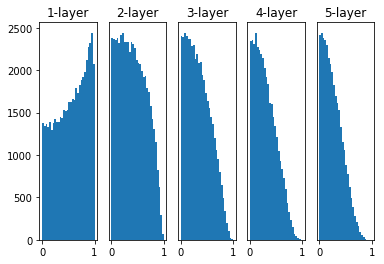

In [50]:
# ヒストグラムを描画
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

### Batch Normalization

アイディア：アクティベーションの分布(またはアクティベーション関数直前)の分布を強制的にばらつかせる  
適切な重みの初期値はアクティベーションがばらつくから

利点
1. 学習速度を上げることができる(学習係数を大きくできる)
2. 性能が初期値に大きく依存しない
3. 過学習を抑制できる(Dropout等を減らせる)

Affineレイヤ -> BatchNormレイヤ -> Activationレイヤ

学習を行う際にミニバッチ単位で正規化を行う
$$
\begin{align}
    \boldsymbol{\mu} &\leftarrow \frac{1}{m}\sum_{i=0}^m\boldsymbol{x}_i \\
    \boldsymbol{\rho_{j}}^2 &\leftarrow \frac{1}{m}\sum_{k=0}^m(\boldsymbol{x}_k - \boldsymbol{\mu})^2 \\
    \hat{\boldsymbol{x}}_i &\leftarrow \frac{\boldsymbol{x}_i - \boldsymbol{\mu}}{\sqrt{\rho_j^2 + \epsilon}}・・・jは特徴量のインデックス
\end{align}
$$

$\epsilon$は10e-7程度  

正規化したデータに対して固有のスケーリングとシフトを行う。  
実際には、学習のforward時に移動平均と移動分散を求めておいて、推論時に移動平均と移動分散を使って特徴量を変換する。  

学習時  
$$
    \tilde{\boldsymbol{x}_{i}} \leftarrow momentum * \tilde{\boldsymbol{x}_{i-1}} + (1 - momentum) * \hat{\boldsymbol{x}}_{i} \\
    \tilde{\rho_{i,j}}^{2} \leftarrow momentum * \tilde{\rho_{i-1,j}}^{2} + (1 - momentum) * \rho_{i,j}^{2}
$$

推論時  
$$
    \hat{\boldsymbol{x}}_i \leftarrow \frac{\boldsymbol{x}_i - \tilde{\boldsymbol{x}_{i}}}{\sqrt{\tilde{\rho_{i,j}}^{2} + \epsilon}}
$$

スケーリング  
$$
    y_i \leftarrow \gamma\hat{x}_i+\beta
$$
$\gamma$と$\beta$はパラメータで初期値$\gamma=1$, $\beta=0$からスタートして学習によって最適化される  
※畳み込み層にも対応する必要があるよ

Batch Normalizationの計算グラフの図解  
<img src="./深層学習_data/NeuralNetwork/スライド2.png">

In [79]:
class BatchNorm:
    def __init__(self, gamma=1.0, beta=0.0, momentum=0.9, running_mean=None, running_var=None):
        self.epsilon_ = 10e-7 # 微小値(ゼロ割Runtime Errorを防ぐ)
        
        self.gamma_ = gamma
        self.beta_ = beta
        self.mu_ = None
        self.var_ = None
        self.std_ = None
        
        self.momentum_ = momentum
        self.running_mean_ = running_mean
        self.running_sigma_ = running_var
        
        self.cX_ = None
        self.normX_ = None
        self.dgamma_ = None
        self.dbeta_ = None
        
        self.batch_size_ = None
        self.input_shape_ = None # CNNの畳み込み層に対応
        
    def forward(self, X, isTrain=True):   
        self.input_shape_ = X.shape
        
        # CNN畳み込み層に対応
        if X.ndim != 2:
            N, C, H, W = X.shape # CNNのbatchデータは4次元データ(データ数, 3次元データ)
            X = X.reshape(N, -1)
            
        outX = self._forward(X, isTrain)
        outX = outX.reshape(*self.input_shape_) # CNNの場合, 4次元データに戻す
        return outX
        
    def _forward(self, X, isTrain):
        # 初回
        if self.running_mean_ is None:
            D = X.shape[1] # 特徴量の列数
            self.running_mean_ = np.zeros(D)
            self.running_var_ = np.zeros(D)
        
        # Batch Norm
        if isTrain:
            self.batch_size_ = X.shape[0]
            mu = np.mean(X, axis=0) # 平均ベクトル
            cX = X - mu # (D,)
            var = (cX**2).mean(axis=0) # 各特徴量ごとの分散
            std = np.sqrt(var + self.epsilon_)
            nX = cX / std # Batch Norm後の特徴行列
            
            # backpropagation時に使う
            self.mu_ = mu
            self.cX_ = cX
            self.std_ = std
            self.var_ = var
            self.normX_ = nX
            
            # 移動平均と移動分散を計算
            self.running_mean_ = self.momentum_*self.running_mean_ + (1.0 - self.momentum_)*self.mu_
            self.running_var_ = self.momentum_*self.running_var_ + (1.0 - self.momentum_)*self.var_
        else:
            # 移動平均と移動分散を使って正規化
            cX = X - self.running_mean_
            nX = cX / np.sqrt(self.running_var_ + self.epsilon_)
        
        # Scaling
        return self.gamma_*nX + self.beta_
    
    def backward(self, dout):
        # CNN畳み込み層に対応
        if dout.ndim != 2:
            N, C, H, W = dout.shape
            dout = dout.reshape(N, -1)
            
        dx = self._backward(dout)
        dx = dx.reshape(*self.input_shape_)
        return dx
    
    def _backward(self, dout):
        # スケーリング変数の微分
        self.dbeta_ = dout.sum(axis=0) # (D,)
        self.dgamma_ = np.sum(self.normX_*dout, axis=0) # (D,)
        
        # 中間値の微分
        dnormX = dout*self.gamma_ # (N,D)
        dcX = dnormX / self.std_ # (N,D)
        ddivX = dnormX*dcX # (N,D)
        dstd = -np.sum(ddivX / (self.std_**2), axis=0) # (D,)
        dvar = 0.5*dstd / self.std_ # (D,)
        #print("dvar.shape", dvar.shape)
        #print("dout.shape", dout.shape)
        N = self.batch_size_
        D = len(dvar)
        dNDvar = np.ones((N, D))*(dvar / N) # (N,D) ※ (D,)のdvarをN分割して(N,D)に分配
        dt = 2.0 * self.cX_ * dNDvar
        dcX += dt
        #print("dcX.shape", dcX.shape)
        dm = np.sum(dcX, axis=0)
        #print("dm.shape", dm.shape)
        
        # 入力Xの微分
        dx = dcX - dm / N
        #print("dx.shape", dx.shape)
        return dx
        

### 多層ニューラルネットワーク  
Weight Decay, Batch Normalization, Dropoutに対応

In [80]:
from collections import OrderedDict

class MultiLayerNetExtend:
    """
    Weight Decay, Batch Normalization, Dropoutに対応
    
    Parameters
    activation: 'relu' or 'sigmoid' or 'tanh' 
    ※relu -> He, sigmoid or tanh -> Xavier　の初期値が良い
    weight_init_std: 標準偏差σを持つ初期値, Heの初期値('he'), Xavierの初期値('xavier')
    weight_decay_labmda: Weight DecayのL2ノルム
    use_dropout: Dropoutの有無
    dropout_ratio: Dropoutさせる割合
    use_batchnorm: Batch Normalizationの有無
    """
    def __init__(self, input_size, hidden_size_list, output_size, 
                 activation='relu', weight_init_std='he', weight_decay_lambda=0,
                 use_dropout=False, dropout_ratio=0.5, use_batchnorm=False):
        
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size_list = hidden_size_list
        self.hidden_layer_num = len(hidden_size_list)
        self.weight_decay_lambda = weight_decay_lambda
        self.use_dropout = use_dropout
        self.dropout_ratio = dropout_ratio
        self.use_batchnorm = use_batchnorm
        self.params = {}
        
        # 重みの初期化
        self.init_weight(weight_init_std)
        
        # レイヤの生成
        activation_layer = {'sigmoid': Sigmoid, 'relu': ReLu, 'tanh': Tanh}
        self.layers = OrderedDict()
        for idx in range(1, self.hidden_layer_num + 1):
            # Affine-Layer
            self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)], self.params['b' + str(idx)])
            
            # BatchNorm-Layer
            if self.use_batchnorm:
                self.params['gamma' + str(idx)] = np.ones(hidden_size_list[idx - 1])
                self.params['beta' + str(idx)] = np.ones(hidden_size_list[idx - 1])
                self.layers['BatchNorm' + str(idx)] = BatchNorm(self.params['gamma' + str(idx)], 
                                                                self.params['beta' + str(idx)])
            
            # Activation-Layer
            self.layers['Activation_function' + str(idx)] = activation_layer[activation]()
            
            # Dropout-Layer
            if self.use_dropout:
                self.layers['Dropout' + str(idx)] = Dropout(dropout_ratio)
            
        # 最終一歩手前のレイヤー
        idx = self.hidden_layer_num + 1
        self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)], self.params['b' + str(idx)])
        
        # 最終レイヤー(Softmax + Loss(CEE, MSE))
        self.last_layer = SoftmaxWithLoss()
            
    def init_weight(self, weight_init_std):
        # これはリスト
        all_size_list = [self.input_size] + self.hidden_size_list + [self.output_size] 
        
        for idx in range(1, len(all_size_list)):
            scale = weight_init_std
            
            if str(weight_init_std).lower() in ('he'):
                scale = np.sqrt(2.0 / all_size_list[idx - 1]) # for ReLu
                
            elif str(weight_init_std).lower() in ('xavier'):
                scale = np.sqrt(1.0 / all_size_list[idx - 1]) # for Sigmoid
                
            self.params['W' + str(idx)] = scale*np.random.randn(all_size_list[idx - 1], all_size_list[idx])
            self.params['b' + str(idx)] = np.zeros(all_size_list[idx])
            
            
    def predict(self, x, isTrain=False):
        for key, layer in self.layers.items():
            if "Dropout" in key or "BatchNorm" in key:
                x = layer.forward(x, isTrain)
            else:
                x = layer.forward(x)
        return x
    
    def loss(self, x, t, isTrain=False):     
        y = self.predict(x, isTrain)
        
        weight_decay = 0 # 荷重減衰項(全体)
        
        for idx in range(1, self.hidden_layer_num + 2): # last-hidden layerとlast-layerとの間の層を含めるから
            W = self.params['W' + str(idx)]
            weight_decay += 0.5*self.weight_decay_lambda*np.sum(W**2)
            
        return self.last_layer.forward(y, t) + weight_decay
    
    def accuracy(self, x, t):
        y = self.predict(x, isTrain=False)
        y = np.argmax(y, axis=1)
        
        # 教師ラベルtがone-hot-vectorの場合変換
        if t.ndim != 1:
            t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
    
    def numericalGradient(self, x, t):
        loss_W = lambda W: self.loss(x, t, isTrain=True)

        grads = {}
        for idx in range(1, self.hidden_layer_num + 2):
            grads['W' + str(idx)] = numerical_gradient(loss_W, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_W, self.params['b' + str(idx)])
            
            if self.use_batchnorm and idx != self.hidden_layer_num+1:
                grads['gamma' + str(idx)] = numerical_gradient(loss_W, self.params['gamma' + str(idx)])
                grads['beta' + str(idx)] = numerical_gradient(loss_W, self.params['beta' + str(idx)])

        return grads
    
    def autoBackGradient(self, x, t):
        # lossの計算(forward)
        self.loss(x, t, isTrain=True)
        
        # backpropagation
        dout = 1
        dout = self.last_layer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout) # 自動微分
        
        # 各レイヤの微分値を抽出
        grads = {}
        for idx in range(1, self.hidden_layer_num + 2):
            grads['W' + str(idx)] = self.layers['Affine' + str(idx)].dW
            grads['W' + str(idx)] += self.weight_decay_lambda*self.params['W' + str(idx)] # 荷重減衰項の微分項
            grads['b' + str(idx)] = self.layers['Affine' + str(idx)].db
            
            if self.use_batchnorm and idx != self.hidden_layer_num + 1:
                grads['gamma' + str(idx)] = self.layers['BatchNorm' + str(idx)].dgamma_
                grads['beta' + str(idx)] = self.layers['BatchNorm' + str(idx)].dbeta_
            
        return grads

BatchNormの勾配チェック

In [81]:
network = MultiLayerNetExtend(input_size=784
                              ,hidden_size_list=[100, 100]
                              ,output_size=10
                              ,use_batchnorm=True)

x_batch = x_train[:1]
print("x_batch.shape", x_batch.shape)
t_batch = t_train[:1]
print("t_batch.shape", t_batch.shape)

grad_numerical = network.numericalGradient(x_batch, t_batch)
grad_backprop = network.autoBackGradient(x_batch, t_batch)
#print("grad_numerical", grad_numerical)
#print("grad_backprop", grad_backprop)

# 各重みの絶対誤差の平均を求める
for key in grad_numerical.keys():
    diff = np.average(np.abs(grad_backprop[key] - grad_numerical[key]))
    print(key + ":" + str(diff))

x_batch.shape (1, 784)
t_batch.shape (1,)
W1:0.0
b1:0.0
gamma1:0.0
beta1:0.0
W2:0.0
b2:0.0
gamma2:0.0
beta2:2.1797360617858975e-12
W3:1.0303536045197514e-10
b3:1.0302869911382739e-10


Stochastic Gradient Descent

In [82]:
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr
    
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr*grads[key]

## Batch Normの有無による学習速度の違い

============== 1/16 ==============


/Users/inoueshinichi/.pyenv/versions/anaconda3-5.0.1/envs/Education/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log
/Users/inoueshinichi/.pyenv/versions/anaconda3-5.0.1/envs/Education/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less_equal
  if __name__ == '__main__':
No handles with labels found to put in legend.
/Users/inoueshinichi/.pyenv/versions/anaconda3-5.0.1/envs/Education/lib/python3.6/site-packages/ipykernel_launcher.py:93: RuntimeWarning: overflow encountered in square
/Users/inoueshinichi/.pyenv/versions/anaconda3-5.0.1/envs/Education/lib/python3.6/site-packages/ipykernel_launcher.py:93: RuntimeWarning: invalid value encountered in double_scalars


============== 2/16 ==============


No handles with labels found to put in legend.


============== 3/16 ==============


No handles with labels found to put in legend.


============== 4/16 ==============


No handles with labels found to put in legend.


============== 5/16 ==============


No handles with labels found to put in legend.


============== 6/16 ==============


No handles with labels found to put in legend.


============== 7/16 ==============


No handles with labels found to put in legend.


============== 8/16 ==============


No handles with labels found to put in legend.


============== 9/16 ==============


No handles with labels found to put in legend.


============== 10/16 ==============


No handles with labels found to put in legend.


============== 11/16 ==============


No handles with labels found to put in legend.


============== 12/16 ==============


No handles with labels found to put in legend.


============== 13/16 ==============


No handles with labels found to put in legend.


============== 14/16 ==============


No handles with labels found to put in legend.


============== 15/16 ==============


No handles with labels found to put in legend.


============== 16/16 ==============


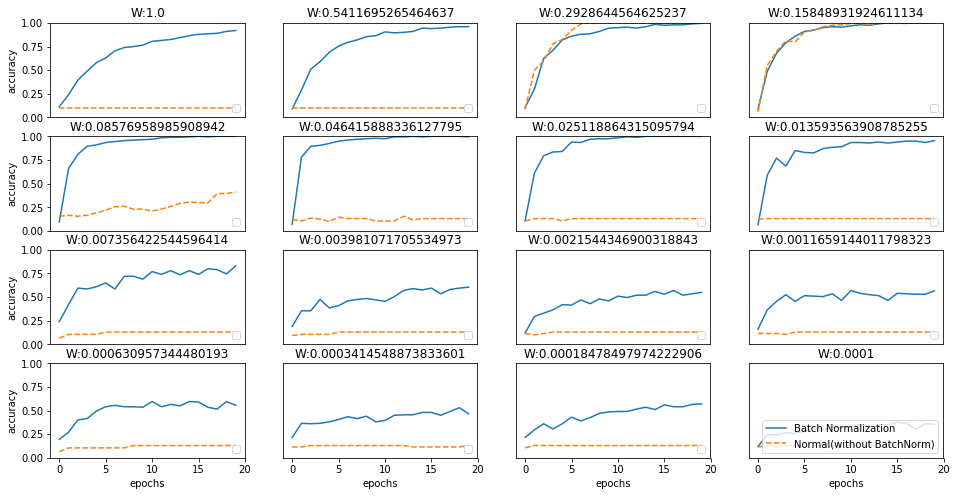

In [101]:
x_train = x_train[:200]
t_train = t_train[:200]

max_epochs = 20
train_size = x_train.shape[0]
batch_size=10
learning_rate = 0.01

optimizer = SGD(lr=learning_rate)

# トレーニングによる正解率
def __train(weight_init_std):
    bn_network = MultiLayerNetExtend(input_size=784
                                    ,hidden_size_list=[100, 100, 100, 100, 100]
                                    ,output_size=10
                                    ,weight_init_std=weight_init_std
                                    ,use_batchnorm=True)
    
    network = MultiLayerNetExtend(input_size=784
                                 ,hidden_size_list=[100, 100, 100, 100, 100]
                                 ,output_size=10
                                 ,weight_init_std=weight_init_std
                                 ,use_batchnorm=False)
    
    train_acc_list = []
    bn_train_acc_list = []
    
    iter_per_epoch = max(train_size / batch_size, 1)
    epoch_cnt = 0
    
    for i in range(1000000000):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]
        
        for _network in (bn_network, network):
            grads = _network.autoBackGradient(x_batch, t_batch)
            optimizer.update(_network.params, grads)
            
        if i % iter_per_epoch == 0:
                train_acc = network.accuracy(x_train, t_train)
                bn_train_acc = bn_network.accuracy(x_train, t_train)
                train_acc_list.append(train_acc)
                bn_train_acc_list.append(bn_train_acc)
                
                #print("epoch:" + str(epoch_cnt) + " | " + str(train_acc) + " - " + str(bn_train_acc))
                
                epoch_cnt += 1
                if epoch_cnt >= max_epochs:
                    break
        
    return train_acc_list, bn_train_acc_list
    
# グラフの描画
weight_scale_list = np.logspace(0, -4, num=16)
x = np.arange(max_epochs)

fig = plt.figure(figsize=(16, 8))
for i, w in enumerate(weight_scale_list):
    print( "============== " + str(i+1) + "/16" + " ==============")
    train_acc_list, bn_train_acc_list = __train(w)
    
    plt.subplot(4,4,i+1)
    plt.title("W:" + str(w))
    
    if i == 15:
        plt.plot(x, bn_train_acc_list, label='Batch Normalization', markevery=2)
        plt.plot(x, train_acc_list, linestyle = "--", label='Normal(without BatchNorm)', markevery=2)
    else:
        plt.plot(x, bn_train_acc_list, markevery=2)
        plt.plot(x, train_acc_list, linestyle="--", markevery=2)
        
    plt.ylim(0, 1.0)
    if i % 4:
        plt.yticks([])
    else:
        plt.ylabel("accuracy")
    if i < 12:
        plt.xticks([])
    else:
        plt.xlabel("epochs")
    plt.legend(loc='lower right')
    
plt.show()

<img src="./深層学習_data/NeuralNetwork/スライド3.png">

Momentum

In [84]:
# Momentum
# v <- αV - η*dL/dW
# W <- W + v
# vは速度, -η*dL/dWが加速度
# 勾配がきつい所ほど、更新の値が大きい
# α 減速項

class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
    
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
        
        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key]
            params[key] += self.v[key]

AdaGrad

In [85]:
# AdaGrad
# learning rate decay 徐々に学習係数を小さくする
# 学習係数を全体で一括して下げるのではなく、一つ一つのパラメータに対して個々で減衰させる
# h <- dL/dW ⦿ dL/dW ※⦿は要素毎の掛け算 つまりhは勾配の２乗和を加算したもの
# W <- W - (η/√h) * dL/dW
# hは学習が進むに連れて、大きくなるが逓減する
# 1/√hはh=0で無限大、hが増加するに連れて小さくなる

class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
        
        for key in params.keys():
            self.h[key] += grads[key]*grads[key]
            params[key] -= self.lr*grads[key] / (np.sqrt(self.h[key]) + 1e-7)

In [86]:
# Adam ≒　Momentum + AdaGrad
class Adam:
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        self.h = 1e-7 # ゼロ割防止の為の微小値

    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)

        self.iter += 1
        lr_t = self.lr*np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)

        for key, val in params.items():
            self.m[key] += (1 - self.beta1)*(grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2)*(grads[key]**2 - self.v[key])
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + self.h)

RMSprop

In [87]:
class RMSprop:
    def __init__(self, lr=0.01, decay_rate=0.99):
        self.lr = lr
        self.decay_rate = decay_rate
        self.h = None
        self.e = 1e-7 # ゼロ割を防ぐための微小値

    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)

        for key in params.keys():
            self.h[key] *= self.decay_rate
            self.h[key] += (1.0 - self.decay_rate)*grads[key]*grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + self.e)

Nesterov

In [88]:
class Nesterov:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None

    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)

        for key in params.keys():
            self.v[key] *= self.v[key]
            self.v[key] -= self.lr*grads[key]
            params[key] += self.momentum*self.momentum*self.v[key]
            params[key] -= (1.0 + self.momentum)*self.lr*self.v[key]

In [89]:
def smooth_curve(x):
    # 畳み込みを利用して曲線をなめらかにする
    # 対象はコスト関数
    window_len = 11
    s = np.r_[x[window_len-1:0:-1], x, x[-1:-window_len:-1]] # 1次元配列の連結？
    w = np.kaiser(window_len, 2)
    y = np.convolve(w/w.sum(), s, mode='valid')
    return y[5:len(y)-5]

学習

In [90]:
import sys
import os
from mnist import load_mnist
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=False)
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


# 最適化手法による学習速度の違い

学習

In [91]:
train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000

optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] =Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()
optimizers['RMSprop'] = RMSprop()
optimizers['Nesterov'] = Nesterov()

networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNetExtend(activation='relu'
                                        ,weight_init_std='he'
                                        ,input_size=784
                                        ,hidden_size_list=[100, 100, 100, 100]
                                        ,output_size=10
                                        ,use_batchnorm=True)
    
    train_loss[key] = []
    
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in optimizers.keys():
        grads = networks[key].autoBackGradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
        
    if i % 200 == 0:
        print("-----" + "iteration:" + str(i) + "-----")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))

/Users/inoueshinichi/.pyenv/versions/anaconda3-5.0.1/envs/Education/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log


-----iteration:0-----
SGD:161.81034209748344
Momentum:107.78914496434379
AdaGrad:69.09107089556913
Adam:162.47899743948045
RMSprop:inf
Nesterov:149.57459115205427
-----iteration:200-----
SGD:0.41235391543065913
Momentum:0.21219074179423553
AdaGrad:0.1116858566577216
Adam:0.22037990822144032
RMSprop:0.09901644161454196
Nesterov:0.4472034966551269
-----iteration:400-----
SGD:0.42285988523919793
Momentum:0.19301772542153767
AdaGrad:0.12876920331489045
Adam:0.1682383667262666
RMSprop:0.0640989109346048
Nesterov:0.4065761261880523
-----iteration:600-----
SGD:0.36068059992726165
Momentum:0.163229802676649
AdaGrad:0.1201983413971802
Adam:0.1559290166663137
RMSprop:0.04697691972279808
Nesterov:0.38352074739462627
-----iteration:800-----
SGD:0.28567476179525075
Momentum:0.14990892220494365
AdaGrad:0.11464709311911991
Adam:0.12425668781385446
RMSprop:0.06286709549526565
Nesterov:0.3314420422201195
-----iteration:1000-----
SGD:0.28626357324074886
Momentum:0.07485592832505049
AdaGrad:0.07407783675

誤差比較

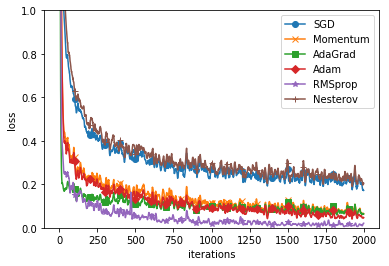

In [92]:
import matplotlib.pyplot as plt
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D", "RMSprop": "*", "Nesterov": "+"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()

<img src="./深層学習_data/NeuralNetwork/スライド4.png">

# Weight Decay（荷重減衰）  
・コスト関数にパラメータのL2ノルム$\frac{1}{2}\lambda||\boldsymbol{W}||$を追加  
・各パラメータの算出した勾配にL2ノルムの微分値$\lambda\boldsymbol{W}$を追加

目的はパラメータ$\boldsymbol{W}$が過大になることを防ぎ、汎化性能を上げる

学習

In [99]:
# 過学習を再現するために、学習データを削減
x_train = x_train[:300]
t_train = t_train[:300]

# weight decay（荷重減衰）の設定
weight_decay_lambda = 0 # weight decayを使用しない場合
#weight_decay_lambda = 0.1

network = MultiLayerNetExtend(input_size=784
                              ,hidden_size_list=[100, 100, 100, 100, 100, 100]
                              ,output_size=10
                              ,use_batchnorm=True
                              ,weight_decay_lambda=weight_decay_lambda)

optimizer = Adam() # lr=0.001, beta1=0.9, beta2=0.99

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.autoBackGradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break

epoch:0, train acc:0.08666666666666667, test acc:0.0936
epoch:1, train acc:0.11666666666666667, test acc:0.1118
epoch:2, train acc:0.17, test acc:0.1463
epoch:3, train acc:0.37666666666666665, test acc:0.2813
epoch:4, train acc:0.6133333333333333, test acc:0.4687
epoch:5, train acc:0.8566666666666667, test acc:0.6064
epoch:6, train acc:0.9133333333333333, test acc:0.6725
epoch:7, train acc:0.9666666666666667, test acc:0.7038
epoch:8, train acc:0.97, test acc:0.7235
epoch:9, train acc:0.9833333333333333, test acc:0.7383
epoch:10, train acc:0.9933333333333333, test acc:0.7594
epoch:11, train acc:0.9933333333333333, test acc:0.7699
epoch:12, train acc:0.9933333333333333, test acc:0.7734
epoch:13, train acc:0.9933333333333333, test acc:0.7742
epoch:14, train acc:0.9933333333333333, test acc:0.7751
epoch:15, train acc:0.9933333333333333, test acc:0.7779
epoch:16, train acc:0.9966666666666667, test acc:0.7779
epoch:17, train acc:1.0, test acc:0.7828
epoch:18, train acc:1.0, test acc:0.7831
e

epoch:193, train acc:1.0, test acc:0.7911
epoch:194, train acc:1.0, test acc:0.7919
epoch:195, train acc:1.0, test acc:0.7919
epoch:196, train acc:1.0, test acc:0.7906
epoch:197, train acc:1.0, test acc:0.7917
epoch:198, train acc:1.0, test acc:0.792
epoch:199, train acc:1.0, test acc:0.7911
epoch:200, train acc:1.0, test acc:0.7914


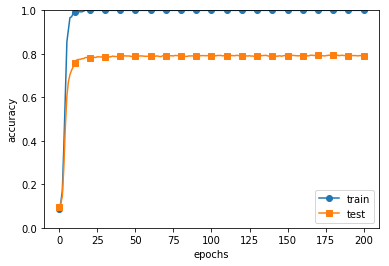

In [100]:
# 3.グラフの描画==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

<img src="./深層学習_data/NeuralNetwork/スライド5.png">

# Dropout

### 過学習の抑制手法

学習時にデータが流れるたびにランダムにニューロン(Activation)に流れるデータを消去する  
(ニューロンに0~1の乱数を与え, dropout_ratioより大きい値を通す)。  
推論時にはニューロンに流れる信号に(1 - dropout_ratio)を掛けて伝達する。

学習

In [124]:
# 過学習を再現するために、学習データを削減
x_train = x_train[:300]
t_train = t_train[:300]

# Dropoutの設定
use_dropout = True
#use_dropout = False
dropout_ratio = 0.4 #0.9 #0.8 #0.7 #0.6 #0.5

network = MultiLayerNetExtend(input_size=784
                              ,hidden_size_list=[100, 100, 100, 100, 100, 100]
                              ,output_size=10
                              ,use_batchnorm=True
                              ,use_dropout=use_dropout)

optimizer = Adam() # lr=0.001, beta1=0.9, beta2=0.99

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.autoBackGradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break

epoch:0, train acc:0.12, test acc:0.1083
epoch:1, train acc:0.08, test acc:0.0943
epoch:2, train acc:0.09, test acc:0.0987
epoch:3, train acc:0.095, test acc:0.1097
epoch:4, train acc:0.135, test acc:0.1402
epoch:5, train acc:0.225, test acc:0.2062
epoch:6, train acc:0.255, test acc:0.236
epoch:7, train acc:0.295, test acc:0.2553
epoch:8, train acc:0.315, test acc:0.2571
epoch:9, train acc:0.335, test acc:0.2923
epoch:10, train acc:0.39, test acc:0.315
epoch:11, train acc:0.435, test acc:0.3277
epoch:12, train acc:0.415, test acc:0.3159
epoch:13, train acc:0.42, test acc:0.3203
epoch:14, train acc:0.39, test acc:0.3054
epoch:15, train acc:0.42, test acc:0.3143
epoch:16, train acc:0.46, test acc:0.3373
epoch:17, train acc:0.465, test acc:0.3432
epoch:18, train acc:0.48, test acc:0.3436
epoch:19, train acc:0.485, test acc:0.345
epoch:20, train acc:0.48, test acc:0.3416
epoch:21, train acc:0.475, test acc:0.345
epoch:22, train acc:0.425, test acc:0.3241
epoch:23, train acc:0.47, test acc:

epoch:192, train acc:0.66, test acc:0.527
epoch:193, train acc:0.655, test acc:0.5278
epoch:194, train acc:0.66, test acc:0.5274
epoch:195, train acc:0.665, test acc:0.5271
epoch:196, train acc:0.67, test acc:0.5295
epoch:197, train acc:0.675, test acc:0.53
epoch:198, train acc:0.67, test acc:0.528
epoch:199, train acc:0.68, test acc:0.5271
epoch:200, train acc:0.665, test acc:0.5207


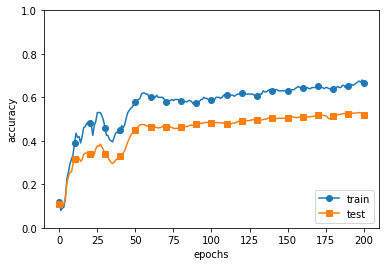

In [125]:
# 3.グラフの描画==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

<img src="./深層学習_data/NeuralNetwork/スライド6.png">

<img src="./深層学習_data/NeuralNetwork/スライド7.png">

# CNN  
1. 畳み込み演算
2. img2col, col2img
3. Pooling(サブサンプリング)

### 畳み込み演算

1次元配列の離散畳み込み演算

$\boldsymbol{x}$　入力シグナル  
$\boldsymbol{w}$　フィルタ(カーネル)  
$$
\begin{align}
    \boldsymbol{y} &= \boldsymbol{x} \ast \boldsymbol{w} = \sum_{-\infty}^{+\infty}\boldsymbol{x}[i-k]\boldsymbol{w}[k] \\
\end{align}
$$
$$
    \boldsymbol{y}[i] = \sum_{k=0}^{m-1}\boldsymbol{x}^{p}[i+m-k]\boldsymbol{w}[k]
$$

<img src="./深層学習_data/NeuralNetwork/スライド8.png">

<img src="./深層学習_data/NeuralNetwork/スライド9.png">

<img src="./深層学習_data/NeuralNetwork/スライド10.png">

<img src="./深層学習_data/NeuralNetwork/スライド11.png">

1次元配列または2次元配列信号の畳み込みは、フィルタを転置してからスライディング・ウィンドウ方式で積和を取れば良い。

1次元配列畳み込み 実装

In [1]:
import numpy as np

def conv1d(x, w, p=0, s=1):
    w_rot = np.array(w[::-1])
    x_padded = np.array(x)
    if p > 0:
        x_padded = np.pad(x_padded, (p,p), 'constant')
    res = []
    for i in range(0, int(len(x)/s),s):
        res.append(np.sum(x_padded[i:i + w_rot.shape[0]]*w_rot))
    return np.array(res)

# テスト
x = [1,3,2,4,5,6,1,3]
w = [1,0,3,1,2]

In [2]:
conv1d(x, w, p=2, s=1)

array([ 5, 14, 16, 26, 24, 34, 19, 22])

In [3]:
np.convolve(x, w, mode='same') # 畳み込み出力ベクトルの要素数が入力ベクトルと同じになるようにpaddingを行う

array([ 5, 14, 16, 26, 24, 34, 19, 22])

2次元配列畳み込み 実装

In [4]:
import scipy.signal

def conv2d(X, W, p=(0,0), s=(1,1)):
    W_rot = np.array(W)[::-1,::-1]
    X_orig = np.array(X)
    X_padded = np.pad(X_orig, [(p[0],p[0]), (p[1],p[1])], "constant")
    res = []
    simax = (X_padded.shape[0]  - W_rot.shape[0]) // s[0] + 1
    sjmax = (X_padded.shape[1]  - W_rot.shape[1]) // s[1] + 1
    for i in range(0,simax,s[0]):
        res.append([])
        for j in range(0,sjmax,s[1]):
            X_sub = X_padded[i:i + W_rot.shape[0], j:j + W_rot.shape[1]]
            res[-1].append(np.sum(X_sub*W_rot))
    return np.array(res)

# テスト
X = [[1,3,2,4], [5,6,1,3], [1,2,0,2], [3,4,3,2]]
W = [[1,0,3], [1,2,1], [0,1,1]]

In [5]:
conv2d(X,W,p=(1,1),s=(1,1))

array([[11, 25, 32, 13],
       [19, 25, 24, 13],
       [13, 28, 25, 17],
       [11, 17, 14,  9]])

In [6]:
scipy.signal.convolve2d(X,W,mode='same')

array([[11, 25, 32, 13],
       [19, 25, 24, 13],
       [13, 28, 25, 17],
       [11, 17, 14,  9]])

<img src="./深層学習_data/NeuralNetwork/スライド12.png">

<img src="./深層学習_data/NeuralNetwork/スライド13.png">

<img src="./深層学習_data/NeuralNetwork/スライド14.png">

img2col実装→ギブアップしてコピペ

In [1]:
def img2col(input_data, filter_h, filter_w, stride=1, pad=0):
    """
    Parameters
    ----------
    input_data : (データ数, チャンネル, 高さ, 幅)の4次元配列からなる入力データ
    filter_h : フィルターの高さ
    filter_w : フィルターの幅
    stride : ストライド
    pad : パディング
    Returns
    -------
    col : 2次元配列
    """
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col

col2img実装→ギブアップしてコピペ

In [2]:
def col2img(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    """
    Parameters
    ----------
    col :
    input_shape : 入力データの形状（例：(10, 1, 28, 28)）
    filter_h :
    filter_w
    stride
    pad
    Returns
    -------
    """
    N, C, H, W = input_shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

    img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]

畳み込み層

In [4]:
class Convolution:
    def __init(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
        
        # 中間データ(backward時に使用)
        self.x = None
        self.col = None
        self.col_W = None
        
        # 重み・バイアスパラメータの勾配
        self.dW = None
        self.db = None
        
    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = 1 + int((H + 2*self.pad - FH) / self.stride)
        out_w = 1 + int((W + 2*self.pad - FW) / self.stride)
        
        col = img2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T
        
        out = np.dot(col, col_W) + self.b
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)
        
        self.x = x
        self.col = col
        self.col_W = col_W
        
        return out
    
    
    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0,2,3,1).reshape(-1,FN)
        
        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)
        
        dcol = np.dot(dout, self.col_W.T)
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)
        
        return dx

Pooling層

In [8]:
class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
        self.x = None
        self.arg_max = None

    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)

        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)

        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        self.x = x
        self.arg_max = arg_max

        return out

    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)
        
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,)) 
        
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        
        return dx

Simple Conv Net

In [ ]:
class SimpleConvNet:
    """単純なConvNet
    
    conv - relu - pool - affine - relu - affine -softmax
    
    """
    
    def __init(self
              ,input_dim=(1,28,28)
              ,conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1}
              ,hidden_size=100
              ,output_size=10
              ,weight_init_std=0.01):
        
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num*(conv_output_size / 2)*(conv_output_size / 2))
        
        # 重みの初期化
        self.params = {}
        self.params['W1'] = weight_init_std*np.random.randn(filter_num
                                                            ,input_dim[0]
                                                            ,filter_size
                                                            ,filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std*np.random.randn(pool_output_size
                                                            ,hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std*np.random.randn(hidden_size
                                                           ,output_size)
        self.params['b3'] = np.zeros(output_size)
        
        # レイヤの生成
        self.layers = OrderDict()
        self.layers['Conv1'] = Convolution(self.params['W1']
                                          ,self.params['b1']
                                          ,conv_param['stride']
                                          ,conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2
                                       ,pool_w=2
                                       ,stride=2)
        self.layers['Affine1'] = Affine(self.params['W2']
                                        ,self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3']
                                       ,self.params['b3'])
        self.last_layer = SoftmaxWithLoss()
        
    def predict(self, X):
        for layer in self.layers.value():
            X = layer.forward(X)
            
        return X
    
    def loss(self, X, t):
        y = self.predict(X)
        return self.last_layer.forward(y,t)
    
    def accuracy(self, X, t, batch_size=100):
        if t.ndim != 1:
            t = np.argmax(t, axis=1)
            
        acc = 0.0
        
        for i in range(int(X.shape[0] / batch_size)):
            tx = X[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt)
            
        return acc / X.shape[0]
    
    def numerialGradient(self, X, t):
        loss_w = lambda w: self.loss(X, t)
        
        grads = {}
        for idx in (1,2,3):
            grads['W' + str(idx)] = numerical_gradient(loss_w, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_w, self.params['b' + str(idx)])
            
        return grads
    
    def autobackGradient(self, X, t):
        # forward
        self.loss(X,t)
        
        # backward
        dout = 1
        dout = self.last_layer.backward(dout)
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
        
        # 設定
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, 
        
            

Deep Conv Net

In [ ]:
class DeepConvNet:
    """MNIST認識率99%以上の高精度なConvNet
    
    ネットワーク構成
    conv - relu - conv - relu - pool -
    conv - relu - conv - relu - pool -
    conv - relu - conv - relu - pool -
    affine - relu - dropout - affine -dropout -softmax
    """
    
    def __init__(self 
                 ,intput_dim=(1, 28, 28)
                 ,conv_param_1 = {'filter_num':16, 'filter_size':3, 'pad':1, 'stride':1}
                 ,conv_param_2 = {'filter_num':16, 'filter_size':3, 'pad':1, 'stride':1}
                 ,conv_param_3 = {'filter_num':32, 'filter_size':3, 'pad':1, 'stride':1}
                 ,conv_param_4 = {'filter_num':32, 'filter_size':3, 'pad':1, 'stride':1}
                 ,conv_param_5 = {'filter_num':64, 'filter_size':3, 'pad':1, 'stride':1}
                 ,conv_param_6 = {'filter_num':64, 'filter_size':3, 'pad':1, 'stride':1}
                 ,hidden_size=50
                 ,outputsize_10):
        
        
    
    